# Análisis Factorial (Exploratorio y Confirmatorio) de variables continuas con R:

## Librerías:
Al usar R en Google Colab debemos:
1.   Instalar los paquetes/librerías (**install.packages("paquete")**) una vez cada vez que abramos el cuaderno de nuevo. Algunos paquetes ya  instalados por defecto en Colab, por lo que debemos pasar directamente al siguiente paso.
2.   Llamar a los paquetes/librerías (**library(paquete)**) una vez cada vez que abramos el cuaderno de nuevo - y tras haberlos instalado.

In [ ]:
install.packages("caret") #Para llevar a cabo la división de la muestra en dos mitades mediante muestreo de las observaciones
library(caret)
install.packages("psych") #Para realizar el AFE, el Análisis Paralelo y otras operaciones como el test de Mardia o el KMO
library(psych)
install.packages("polycor") #Para estimar la matriz policórica o tetracórica según el caso
library(polycor)
install.packages("ggcorrplot") #Para graficar las correlaciones obtenidas mediante un mapa de calor
library(ggcorrplot)
install.packages("GPArotation") #Para poder rotar los factores
library(GPArotation)
install.packages("lavaan") #Para realizar el AFC
library(lavaan)

## Datos:

In [32]:
set.seed(1000) #Establecemos una semilla para facilitar la reproductibilidad de los resultados

#Simulamos un dataset de 1000 jugadores de futbol 
#Las variables simuladas son: Altura, Peso, Ganancias y Partidos. Altura y Peso estarán correladas, y lo mismo Ganancias y Partidos.
#La estructura factorial teórica es, por tanto, de dos factores: Altura-Peso y Ganancias-Partidos.

cov_Altura_Peso        <- 0.7*sqrt((20^2)*(15^2)) #La covarianza entre X e Y es igual al producto de su correlación por sus desviaciones típicas
cov_Ganancias_Partidos <- 0.8*sqrt((150^2)*(50000^2))

cov_matriz <- rbind(c(            20^2, cov_Altura_Peso,                      0,                      0),
                    c( cov_Altura_Peso,            15^2,                      0,                      0),
                    c(               0,               0,                50000^2, cov_Ganancias_Partidos),
                    c(               0,               0, cov_Ganancias_Partidos,                  150^2))

mu <- c(170, 75, 250000, 400)

datos_correlados <- as.data.frame(mvrnorm(n=5000, mu=mu, Sigma=cov_matriz))

datos <- data.frame(
  ID        = seq(from=1, to=5000),               #Creamos una columna de IDs que nos será útil para dividir la muestra
  Altura    = round(abs(datos_correlados[,1]),2), #La altura sigue una normal N(170, 20). Usamos la función abs() (valor absoluto), para evitar alturas negativas
  Peso      = round(abs(datos_correlados[,2]),2), #El peso sigue una normal N(75, 15)
  Ganancias = round(abs(datos_correlados[,3]),2), #Los ingresos siguen una normal N(250000, 50000)
  Partidos  = round(abs(datos_correlados[,4]),2)  #Los partidos siguen una normal N(400, 150)
)
head(datos)

,ID,Altura,Peso,Ganancias,Partidos
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,190.95,83.26,227710.6,546.42
2,2,163.09,69.68,189707.2,227.93
3,3,168.71,67.31,252056.0,545.05
4,4,168.29,77.24,281969.7,376.18
5,5,190.45,92.66,210672.2,351.59
6,6,122.78,42.16,230725.4,399.56


In [33]:
#Como vamos a hacer un doble Análisis Factorial - exploratorio y confirmatorio - vamos a dividir la muestra en aproximadamente el 50%
#Realizando el Exploratorio sobre una mitad, y el Confirmatorio sobre la otra, para ver si los resultados concuerdan
set.seed(2021) #Establecemos una semilla para facilitar la reproductibilidad de los resultados
datos.ids <- createDataPartition(datos$ID, p=0.5, list=F)
#Obtenemos mediante muestreo aleatorio el 50% de las observaciones (identificadas mediante la columna de ID del alumno)
datos_AFE <- datos[datos.ids, ] #Para el Exploratorio solo conservamos las observaciones cuyos IDs han sido muestreados
dim(datos_AFE) #2500 observaciones
datos_AFC <- datos[-datos.ids, ] #Para el COnfirmatorio solo conservamos las observaciones cuyos IDs no han sido muestreados
dim(datos_AFC) #2500 observaciones
#Eliminamos la columna de IDs, ya que no nos hace falta:
datos_AFE$ID <- NULL
datos_AFC$ID <- NULL

[1] 2500    5

[1] 2500    5

## Análisis Factorial Exploratorio (AFE):

### Pruebas de normalidad de los datos:
(Paso previo antes de llevar a cabo un Análisis Factorial. Necesario para saber qué método de extracción de factores debemos emplear).

Call: mardia(x = datos_AFE, na.rm = TRUE)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 2500   num.vars =  4 
b1p =  0.04   skew =  16.05  with probability  <=  1.4
 small sample skew =  16.08  with probability <=  1.4
b2p =  23.84   kurtosis =  -0.57  with probability <=  0.57

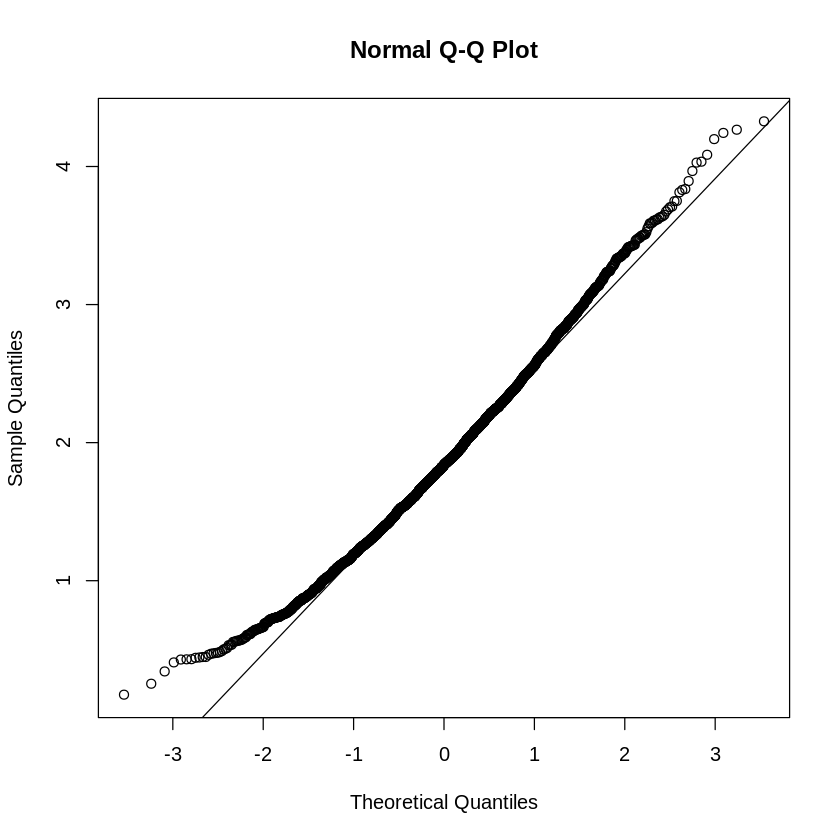

In [34]:
#Test de Mardia de normalidad multivariante:
mardia(datos_AFE, na.rm = TRUE)
#Como los p-valores son superiores a los niveles de significación habituales (10%, 5% y 1%) no se rechaza la hipótesis nula, es decir, o se rechaza la normalidad de los datos
#Por tanto, podemos usar un método de extracción de factores que requiera de normalidad multivariante, como es el caso de Maxima Verosimilitud (Maximum Likelihood, ML)

###Estimación de la matriz de correlaciones:
La matriz de correlaciones de Pearson y la de Spearman son las más apropiadas ante continuos o ante datos ordinales (categóricos) con más de 7 categorías de respuesta (tienden a la continuidad).

Por su parte, la matriz de correlaciones policórica es la más recomendada ante datos ordinales de 7 o menos categorías de respuesta. Específicamente, si tuviéramos datos dicotómicos, la matriz a emplear sería la matriz tetracórica (similar a la policórica pero con datos dicotómicos).

En nuestro caso, como tenemos datos continuos, usaremos la matriz de correlaciones de Pearson.

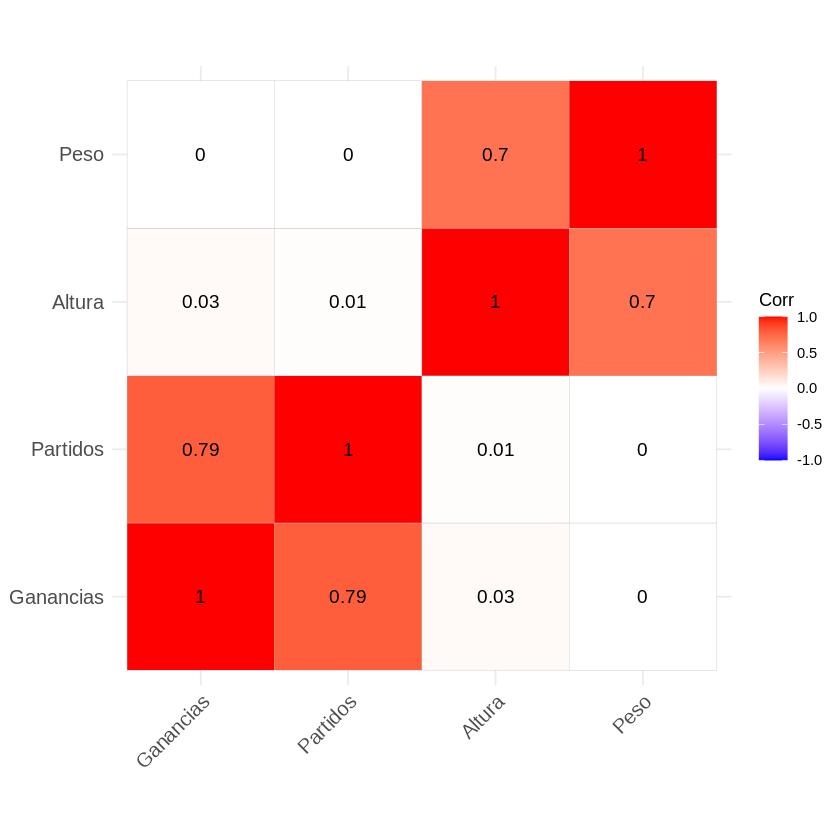

In [35]:
matriz_correlaciones <- cor(datos_AFE, method = "pearson")
ggcorrplot(matriz_correlaciones,hc.order = T, lab=T)

### Verificamos que la matriz sea factorizable:
(Paso previo antes de llevar a cabo un AFE. Si la matriz no fuese factorizable, la relación entre las variables sería tan baja que no se formarían factores).

Vamos a usar tres pruebas diferentes para comprobar si la matriz es factorizable:
* Test de esfericidad de Bartlett: si rechazamos la hipótesis nula (la matriz de correlaciones es la matriz identidad), la matriz será afctorizable
* Medida KMO (Kaiser-Meyer-Olkin): valores superiores a 0,75 indican que la matriz es factorizable.
* Determinante de la matriz: valores cercanos a cero indican que la matriz es factorizable.

In [36]:
p_esf <- cortest.bartlett(matriz_correlaciones, n=252)
p_esf$p.value
#El p-valor es menor a los niveles de significación habituales(10%, 5% y 1%) por lo que rechazamos la hipótesis nula: la matriz no es la matriz identidad
KMO(matriz_correlaciones)
#El resultado del KMO es de 0,5
det(matriz_correlaciones)
#El determinante tiene un valor no excesivamente bajo: 0.194728602740068
#En general, los test no arrojan resultados óptimos, pero continuamos adelante con el AFE

[1] 8.200818e-85

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = matriz_correlaciones)
Overall MSA =  0.5
MSA for each item = 
   Altura      Peso Ganancias  Partidos 
      0.5       0.5       0.5       0.5 

[1] 0.1947286

### Determinamos el número de factores a extraer:
Existen cuatro métodos principales:
* Regla de Kaiser: se deben aceptar todos aquellos factores con un autovalor mayor a 1.
* Gráfico de sedimentación (*scree plot*): gráfico donde podemos ver cómo disminuye la varianza explicada o el autovalor a medida que vamos aumentando el número de factores a extraer. 
* Establecimiento de un porcentaje de varianza explicada mínimo (por ejemplo, el 75%): cogeríamos todos los factores necesarios para explicar ese porcentaje mínimo de varianza.
* Análisis paralelo (método recomendado): el AP parte de generar nuevas muestras aleatorias (mínimo 100) con las mismas variables y observaciones que la muestra original y, a partir de ello, se queda con aquellos factores cuyo autovalor es superior a los generados por azar. 

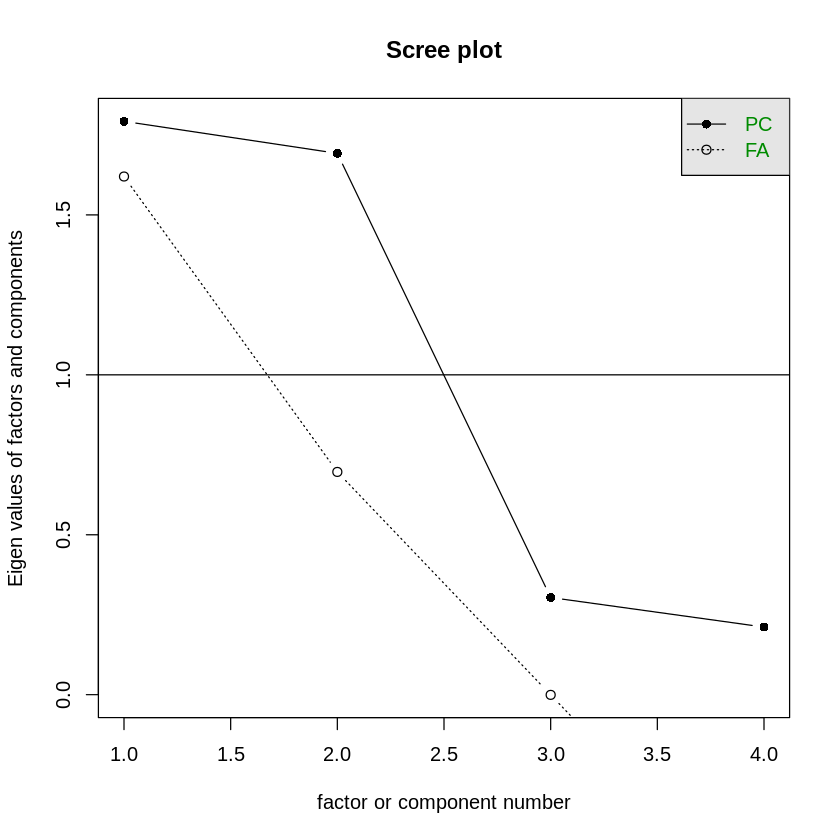

Parallel analysis suggests that the number of factors =  2  and the number of components =  NA 


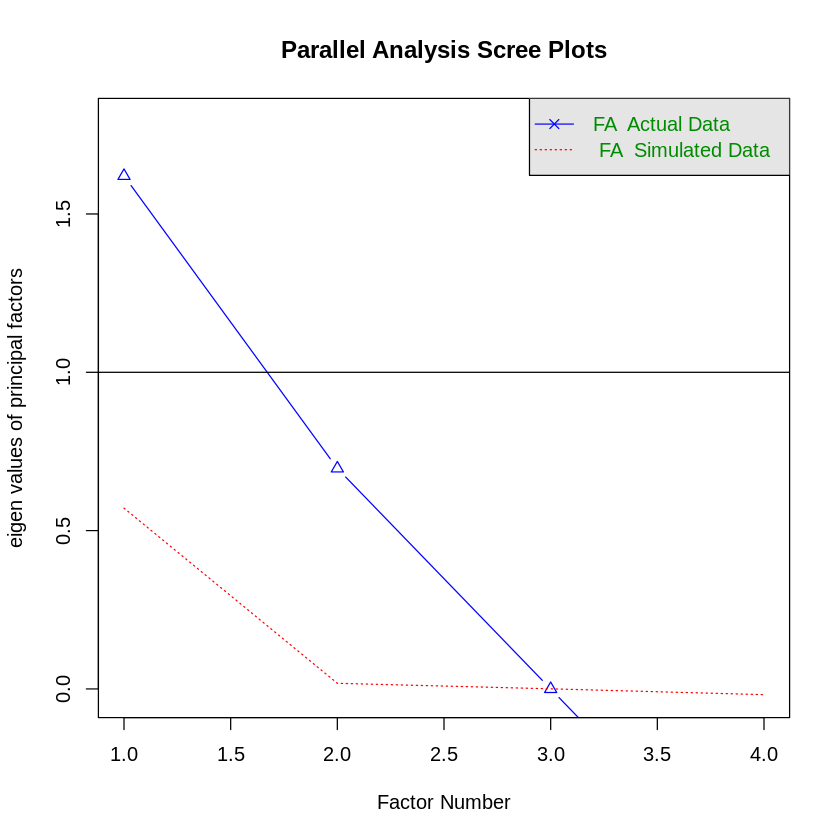

In [38]:
#Gráfico de sedimentación con la regla de Kaiser marcada:
scree(matriz_correlaciones)
#Análisis paralelo:
fa.parallel(matriz_correlaciones, n.obs=nrow(datos_AFE), n.iter=500, fa="fa", fm="ml")
#El Análisis Paralelo sugiere la extracción de dos factores y la regla de Kaiser, de 1
#Haremos caso al Análisis Paralelo, por ser la técnica más recomendada actualmente. Además está en línea con los que esperábamos teóricamente.

### Extracción de factores:
Vamos a extraer tres factores, siguiendo lo recomendado por el Análisis Paralelo.

Asimismo, debemos decidir si vamos a rotar los factores (cuestión que se recomienda) y qué tipo de rotación vamos a emplear. Dos tipos:
* Rotación oblicua: permite que los factores puedan tener correlación entre ellos. Tipo recomendado, ya que es el más cercano a la estructura real que deseamos explorar. Un ejemplo es el método *oblimin*.
* Rotación ortogonal: fuerza a los factores a que no puedan tener correlación entre ellos. Un ejemplo es el método *varimax*.

Cuanto mayor sea el peso factorial de un ítem en un factor mejor. Se aceptan pesos factoriales por encima de 0,4.

Factor Analysis using method =  ml
Call: fa(r = matriz_correlaciones, nfactors = 2, n.obs = nrow(datos_AFE), 
    rotate = "oblimin", fm = "ml", alpha = 0.05)
Standardized loadings (pattern matrix) based upon correlation matrix
            ML1   ML2   h2    u2 com
Altura     0.00  1.00 1.00 0.005   1
Peso      -0.01  0.70 0.49 0.513   1
Ganancias  1.00  0.00 1.00 0.005   1
Partidos   0.79 -0.01 0.62 0.375   1

                       ML1  ML2
SS loadings           1.62 1.48
Proportion Var        0.40 0.37
Cumulative Var        0.40 0.78
Proportion Explained  0.52 0.48
Cumulative Proportion 0.52 1.00

 With factor correlations of 
     ML1  ML2
ML1 1.00 0.02
ML2 0.02 1.00

Mean item complexity =  1
Test of the hypothesis that 2 factors are sufficient.

The degrees of freedom for the null model are  6  and the objective function was  1.64 with Chi Square of  4085.19
The degrees of freedom for the model are -1  and the objective function was  0 

The root mean square of the residuals (RMSR

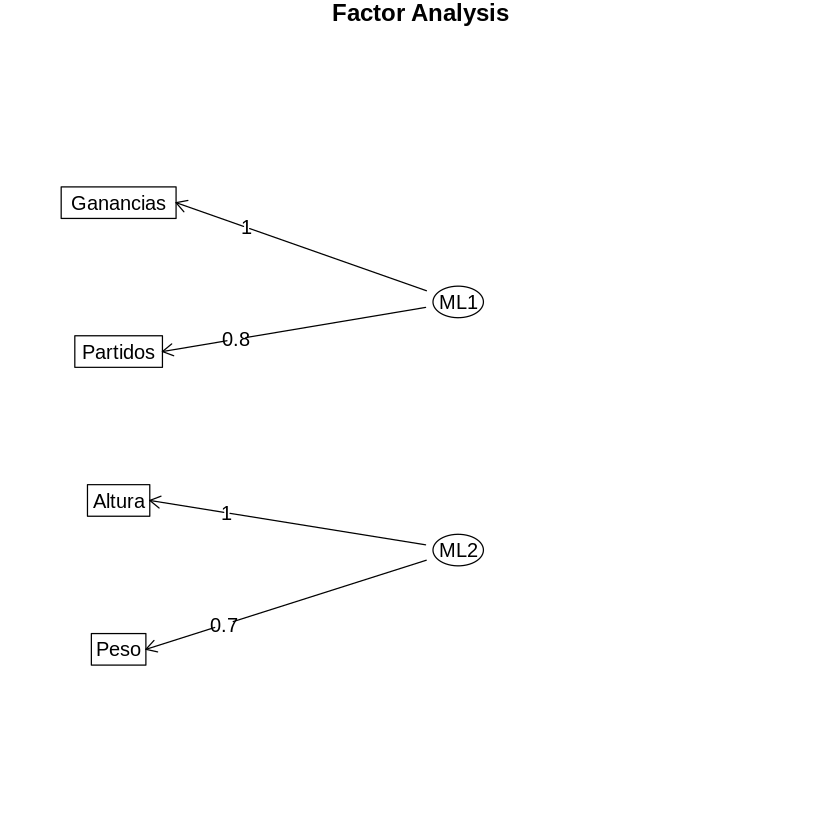

In [42]:
#Con rotación oblicua oblimin:
AFE_oblimin <- fa(matriz_correlaciones, nfactors=2, n.obs=nrow(datos_AFE), rotate="oblimin", fm="ml", alpha=0.05)
AFE_oblimin
fa.diagram(AFE_oblimin)
#Vemos que los items que más pesan en el factor 1 son los correspondientes a las variables Ganancias y Partidos
#Los items que más pesan en el factor 2 son los correspondientes a las variables Altura y Peso
#Los índices de bondad del ajuste son muy buenos: RMSEA es inferior a 0,08 y TLI mayor a 0,95
#En el gráfico vemos que los factores no están ligeramente correlacionados
#A los pesos factoriales de 1 (el de la variable Partidos en el Factor 1, y el de la variable Altura en el 2) se les denomina "casos Heywood". Lo ideal es no tenerlos, aunque, por suerte, no son superiores a 1, lo que ya sería incorrecto
#Como hemos visto que los factores no están correlacionados, es posible que estos casos Heywood que tenemos se deban a usar un método de rotación oblicuo, y no uno ortogonal

Factor Analysis using method =  ml
Call: fa(r = matriz_correlaciones, nfactors = 2, n.obs = nrow(datos_AFE), 
    rotate = "varimax", fm = "ml", alpha = 0.05)
Standardized loadings (pattern matrix) based upon correlation matrix
           ML1   ML2   h2    u2 com
Altura    0.24  0.97 1.00 0.005 1.1
Peso      0.16  0.68 0.49 0.513 1.1
Ganancias 0.97 -0.22 1.00 0.005 1.1
Partidos  0.77 -0.18 0.62 0.375 1.1

                       ML1  ML2
SS loadings           1.62 1.48
Proportion Var        0.41 0.37
Cumulative Var        0.41 0.78
Proportion Explained  0.52 0.48
Cumulative Proportion 0.52 1.00

Mean item complexity =  1.1
Test of the hypothesis that 2 factors are sufficient.

The degrees of freedom for the null model are  6  and the objective function was  1.64 with Chi Square of  4085.19
The degrees of freedom for the model are -1  and the objective function was  0 

The root mean square of the residuals (RMSR) is  0 
The df corrected root mean square of the residuals is  NA 

The har

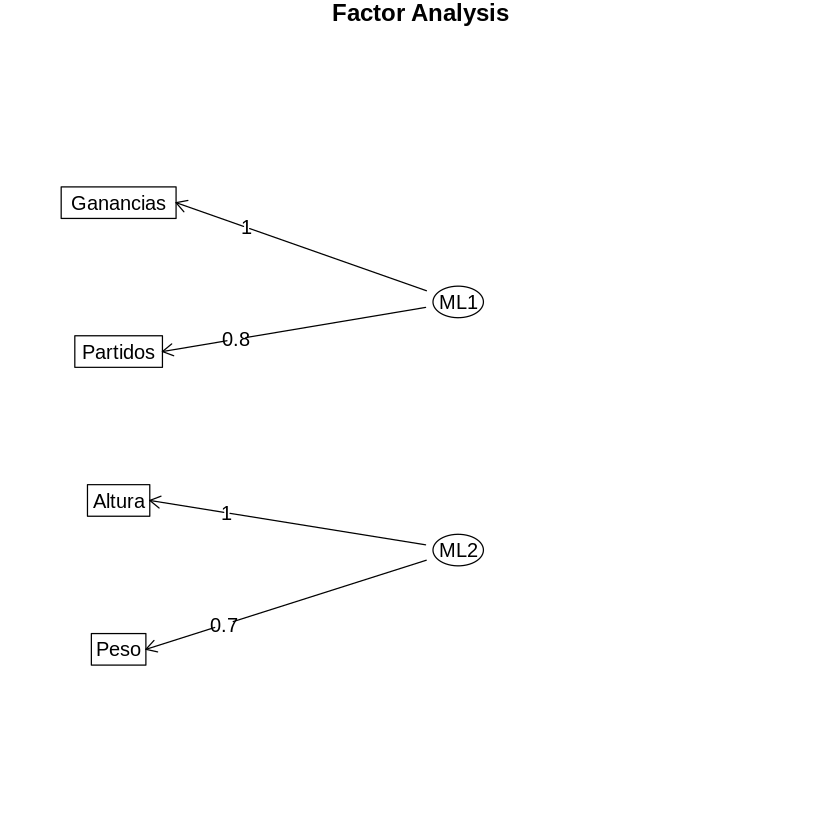

In [43]:
#Con rotación ortogonal varimax:
AFE_varimax <- fa(matriz_correlaciones, nfactors=2, n.obs=nrow(datos_AFE), rotate="varimax", fm="ml", alpha=0.05)
AFE_varimax
fa.diagram(AFE_varimax)
#Vemos que los resultados son caso idénticos, salvo porque se solucionan los casos Heywood
#Como los factores no estaban correlacionados, tenía más sentido usar una rotación ortogonal

### Resultados AFE:
La estructura factorial obtenida concuerda con la estructura factorial teórica de dos factores.

## Análisis Factorial Confirmatorio (AFC):

### Pruebas de normalidad de los datos:

Call: mardia(x = datos_AFC, na.rm = TRUE)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 2500   num.vars =  4 
b1p =  0.03   skew =  13.02  with probability  <=  1.8
 small sample skew =  13.04  with probability <=  1.8
b2p =  23.58   kurtosis =  -1.51  with probability <=  0.13

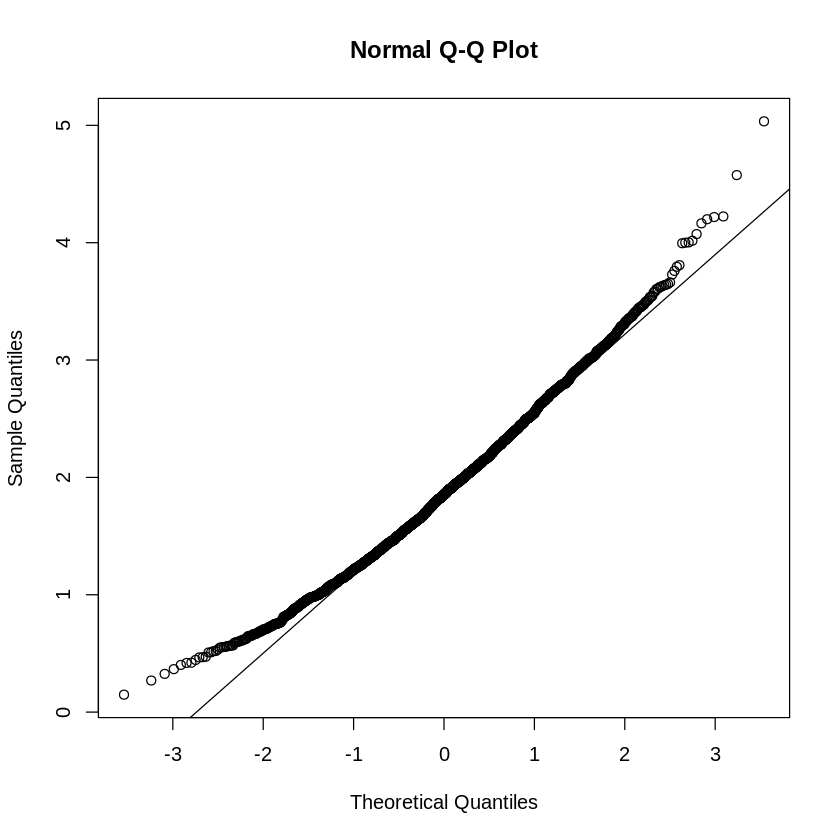

In [44]:
mardia(datos_AFC, na.rm = TRUE)
#Como los p-valores son superiores a los niveles de significación habituales (10%, 5% y 1%) no se rechaza la hipótesis nula, es decir, o se rechaza la normalidad de los datos
#Por tanto, podemos usar un método de extracción de factores que requiera de normalidad multivariante, como es el caso de Maxima Verosimilitud (Maximum Likelihood, ML)

### Modelos a probar:
Vamos a probar con un modelo de un solo factor y un modelo de dos factores.

Para comparar modelos nos vamos a fijar en los índices de bondad del ajuste: la situación óptima es aquella en la que los índices SRMR y RMSEA son inferiores a 0,8 - cuanto más bajos mejor -, y los índices TLI y CFI son superiores a 0,95 - cuanto más altos mejor.

No obstante, antes de probar los modelos, debemos estandarizar las variables (media 0, desviación típica 1), porque si no, la librería *lavaan* nos dará problemas, ya que las unidades de medida de las distintas variables son muy diferentes.

In [52]:
datos_AFC_estandarizados <- scale(datos_AFC)

### Modelo con un factor:

In [48]:
#Especificamos el modelo: en este modelo se respetan los tres factores teóricos:
modelo1F <- 'Factor =~ Altura + Peso + Ganancias + Partidos'
#Realizamos el factorial:
factorial1F <- cfa(modelo1F, datos_AFC_estandarizados, estimator="ML", ordered=FALSE, orthogonal=TRUE)
#Usamos la opción ordered=FALSE porque las variables no son categóricas
#Al usar la opción orthogonal=TRUE estamos diciendo que no puede haber correlación entre factores
summary(factorial1F, fit.measures=TRUE, standardized=TRUE)
#Nos despliega una gran cantidad de información, pero lo esencial es fijarse en los índices de bondad del ajuste:
#El modelo no es bueno, ya que R no es capaz de encontrar una solución

Warning message in lavaan::lavaan(model = modelo1F, data = datos_AFC_scale, ordered = FALSE, :
“lavaan WARNING:
    the optimizer warns that a solution has NOT been found!”


lavaan 0.6-9 did NOT end normally after 1433 iterations
** WARNING ** Estimates below are most likely unreliable

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         8
                                                      
  Number of observations                          2500
                                                      
Model Test User Model:
                                                      
  Test statistic                                    NA
  Degrees of freedom                                NA


Warning message in .local(object, ...):
“lavaan WARNING: fit measures not available if model did not converge

”



Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  Factor =~                                                             
    Altura            1.000                              28.401   28.396
    Peso              0.001       NA                      0.025    0.025
    Ganancias        -0.000       NA                     -0.001   -0.001
    Partidos          0.000       NA                      0.001    0.001

Variances:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
   .Altura         -805.618       NA                   -805.618 -805.337
   .Peso              0.999       NA                      0.999    0.999
   .Ganancias         1.000       NA                      1.000    1.000
   .Partidos          1.000       NA               

### Modelo con dos factores:
Este modelo sigue la estructura factorial teórica.

In [54]:
modelo2F <- 'Factor1 =~ Altura + Peso
             Factor2 =~ Ganancias + Partidos'
#Realizamos el factorial:
factorial2F <- cfa(modelo2F, datos_AFC_estandarizados, estimator="ML", ordered=FALSE, orthogonal=TRUE)
summary(factorial2F, fit.measures=TRUE, standardized=TRUE)
#El ajuste es bueno: RMSEA y SRMR <= 0,08, y TLI y CFI > 0.95
#Además, el modelo converge, no como en el caso de un factor

Warning message in lav_model_vcov(lavmodel = lavmodel, lavsamplestats = lavsamplestats, :
“lavaan WARNING:
    Could not compute standard errors! The information matrix could
    not be inverted. This may be a symptom that the model is not
    identified.”


lavaan 0.6-9 ended normally after 18 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         8
                                                      
  Number of observations                          2500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 3.252
  Degrees of freedom                                 2
  P-value (Chi-square)                           0.197

Model Test Baseline Model:

  Test statistic                              4400.854
  Degrees of freedom                                 6
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000
  Tucker-Lewis Index (TLI)                       0.999

Loglikelihood and Information Criteri

### Resultados AFC:
Los índices de bondad del ajuste - y el hecho de que solo el modelo de dos factores converja - muestran que el modelo que refleja la estructura de los dos factores teóricos es el que mejor ajusta ajusta. Su ajuste a los datos es muy bueno.

## Resultados finales:
Los resultados de los análisis factoriales - exploratorio y confirmatorio - están en sintonía, indicando que el modelo con los dos factores teóricos es el que mejor ajusta. Por todo ello, podemos considerar que existen los siguientes dos factores:
*   Factor 1: variables Altura y Peso. Factor "físico".
*   Factor 2: variables Ganancias y Partidos. Factor "económico-deportivo".

